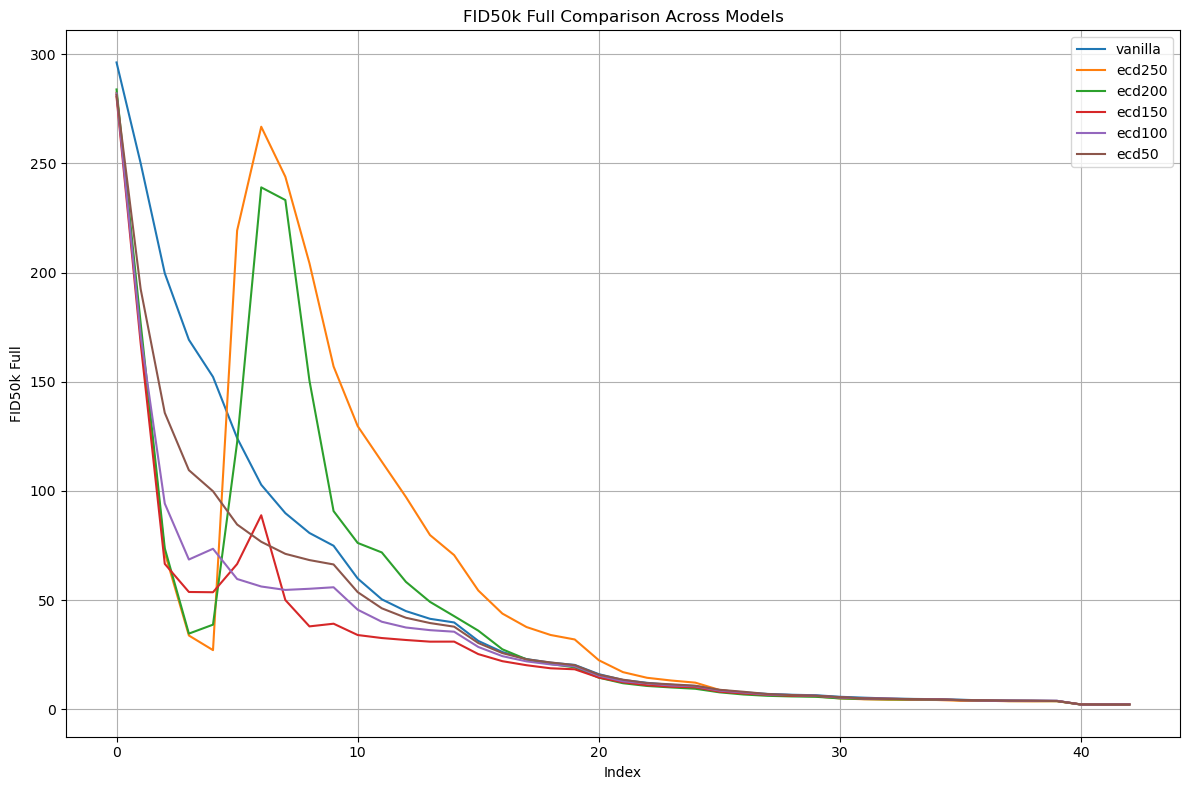

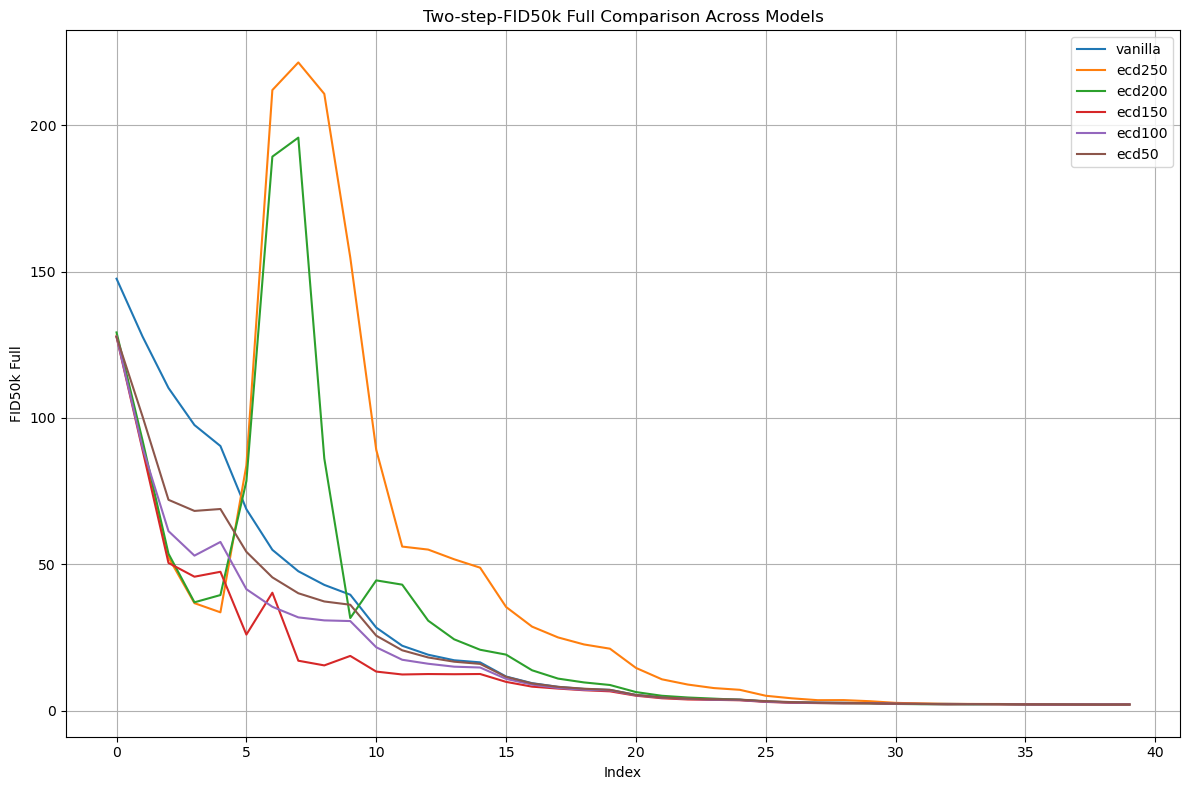

In [125]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# 폴더 및 파일 이름
folders_one = {
    "vanilla": "vanilla/00000-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k/metric-fid50k_full.jsonl",
    "ecd250": "ecd/00030-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu250/metric-fid50k_full.jsonl",
    "ecd200": "ecd/00032-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu200/metric-fid50k_full.jsonl",
    "ecd150": "ecd/00034-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu150/metric-fid50k_full.jsonl",
    "ecd100": "ecd/00033-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu100/metric-fid50k_full.jsonl",
    "ecd50": "ecd/00035-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu50/metric-fid50k_full.jsonl"
}

folders_two = {
    "vanilla": "vanilla/00000-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k/metric-two_step_fid50k_full.jsonl",
    "ecd250": "ecd/00030-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu250/metric-two_step_fid50k_full.jsonl",
    "ecd200": "ecd/00032-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu200/metric-two_step_fid50k_full.jsonl",
    "ecd150": "ecd/00034-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu150/metric-two_step_fid50k_full.jsonl",
    "ecd100": "ecd/00033-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu100/metric-two_step_fid50k_full.jsonl",
    "ecd50": "ecd/00035-cifar10-32x32-uncond-ddpmpp-ect-RAdam-0.000100-gpus2-batch128-fp32-bs128.200k.mu50/metric-two_step_fid50k_full.jsonl"
}

# 색상 설정
colors = {
    "vanilla": "#1f77b4",  # 파란색
    "ecd250": "#ff7f0e",  # 주황색
    "ecd200": "#2ca02c",  # 초록색
    "ecd150": "#d62728",  # 빨간색
    "ecd100": "#9467bd",  # 보라색
    "ecd50":  "#8c564b"   # 갈색
}

# 그래프 초기화
plt.figure(figsize=(12, 8))

# 각 파일 데이터를 읽고 플롯
for label, filepath in folders_one.items():
    # 데이터 로드
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    
    # pandas DataFrame으로 변환
    df = pd.DataFrame(data)
    df['fid50k_full'] = df['results'].apply(lambda x: x['fid50k_full'])
    
    # 그래프 그리기
    plt.plot(df.index, df['fid50k_full'], marker='', color=colors[label], label=label)

# 그래프 꾸미기
plt.xlabel('Index')
plt.ylabel('FID50k Full')
plt.title('FID50k Full Comparison Across Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 그래프 초기화
plt.figure(figsize=(12, 8))

# 각 파일 데이터를 읽고 플롯
for label, filepath in folders_two.items():
    # 데이터 로드
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    
    # pandas DataFrame으로 변환
    df = pd.DataFrame(data)
    df['fid50k_full'] = df['results'].apply(lambda x: x['fid50k_full'])
    
    # 그래프 그리기
    plt.plot(df.index, df['fid50k_full'], marker='', color=colors[label], label=label)

# 그래프 꾸미기
plt.xlabel('Index')
plt.ylabel('FID50k Full')
plt.title('Two-step-FID50k Full Comparison Across Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:

class ECDLoss:
    def __init__(self, P_mean=-1.1, P_std=2.0, sigma_data=0.5, q=2, c=0.0, k=8.0, b=1.0, cut=4.0, adj='sigmoid', reg=False, lamd = 0.1, ):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data
        
        self.reg = reg
        self.lamd = lamd
        
        if adj == 'const':
            self.t_to_r = self.t_to_r_const
            self.mu = self.mu_const
        elif adj == 'sigmoid':
            self.t_to_r = self.t_to_r_sigmoid
            self.mu = self.mu_sigmoid
        else:
            raise ValueError(f'Unknow schedule type {adj}!')

        self.q = q
        self.stage = 0
        self.ratio = 0.

        self.stage_mu = 0
        self.ratio_mu = 0.
        
        self.k = k
        self.b = b

        self.c = c

    def update_schedule(self, stage):
        self.stage = stage
        self.ratio = 1 - 1 / self.q ** (stage+1)

    def t_to_r_const(self, t):
        decay = 1 / self.q ** (self.stage+1)
        ratio = 1 - decay
        r = t * ratio
        return torch.clamp(r, min=0)

    def t_to_r_sigmoid(self, t):
        adj = 1 + self.k * torch.sigmoid(-self.b * t)
        decay = 1 / self.q ** (self.stage+1)
        ratio = 1 - decay * adj
        r = t * ratio
        return torch.clamp(r, min=0)
    
    def update_schedule_mu(self, stage_mu):
        self.stage_mu = stage_mu
        self.ratio_mu = 1 - 1 / self.q ** (stage_mu+1)

    def mu_const(self, t):
        decay = 1 / self.q ** (self.stage_mu+1)
        ratio = 1 - decay
        return torch.clamp(torch.tensor(ratio, dtype=t.dtype), min=0)
    
    def mu_sigmoid(self, t):
        adj = 1 + self.k * torch.sigmoid(-self.b * t)
        decay = 1 / self.q ** (self.stage_mu+1)
        ratio = 1 - decay * adj
        return torch.clamp(ratio, min=0)

    def __call__(self, net, images, labels=None, augment_pipe=None):
        # t ~ p(t) and r ~ p(r|t, iters) (Mapping fn)
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
        t = (rnd_normal * self.P_std + self.P_mean).exp()
        r = self.t_to_r(t)

        # Augmentation if needed
        y, augment_labels = augment_pipe(images) if augment_pipe is not None else (images, None)
        
        # Shared noise direction
        eps   = torch.randn_like(y)
        eps_t = eps * t
        eps_r = eps * r

        # Shared Dropout Mask
        rng_state = torch.cuda.get_rng_state()
        yt = y + eps_t
        D_yt = net(yt, t, labels, augment_labels=augment_labels)
        
        if r.max() > 0:
            torch.cuda.set_rng_state(rng_state)
            with torch.no_grad():
                rt = r / t
                mu = self.mu(t)
                yr_hat = rt * yt + (1 - rt) * D_yt
                yr_bar = (1 - mu) * yr_hat + mu * (y + eps_r)
                D_yr = net(yr_bar, r, labels, augment_labels=augment_labels)
            
            mask = r > 0
            D_yr = torch.nan_to_num(D_yr)
            D_yr = mask * D_yr + (~mask) * y
        else:
            D_yr = y

        # L2 Loss
        loss = (D_yt - D_yr) ** 2
        if self.reg:
            loss = loss + self.lamd * ((yr_hat - (y + eps_r)) ** 2)
        loss = torch.sum(loss.reshape(loss.shape[0], -1), dim=-1)
        
        # Producing Adaptive Weighting (p=0.5) through Huber Loss
        if self.c > 0:
            loss = torch.sqrt(loss + self.c ** 2) - self.c
        else:
            loss = torch.sqrt(loss)
        
        # Weighting fn
        return loss / (t - r).flatten()

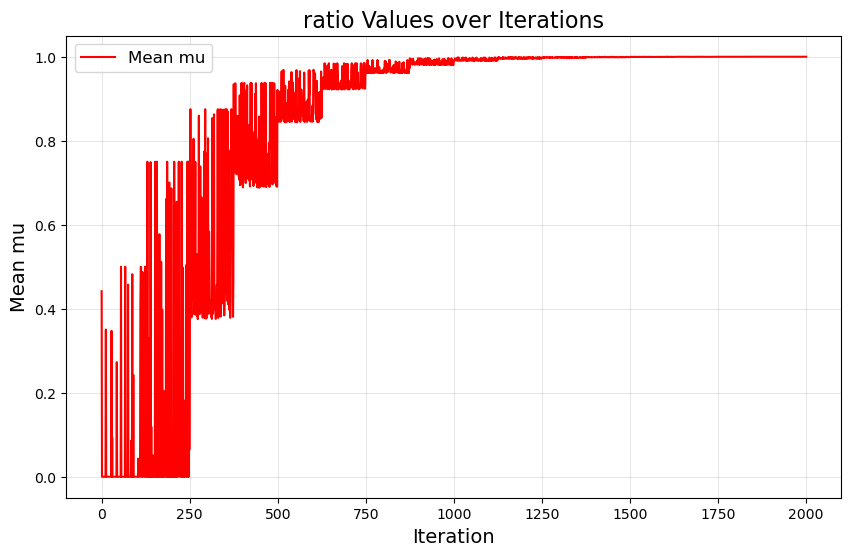

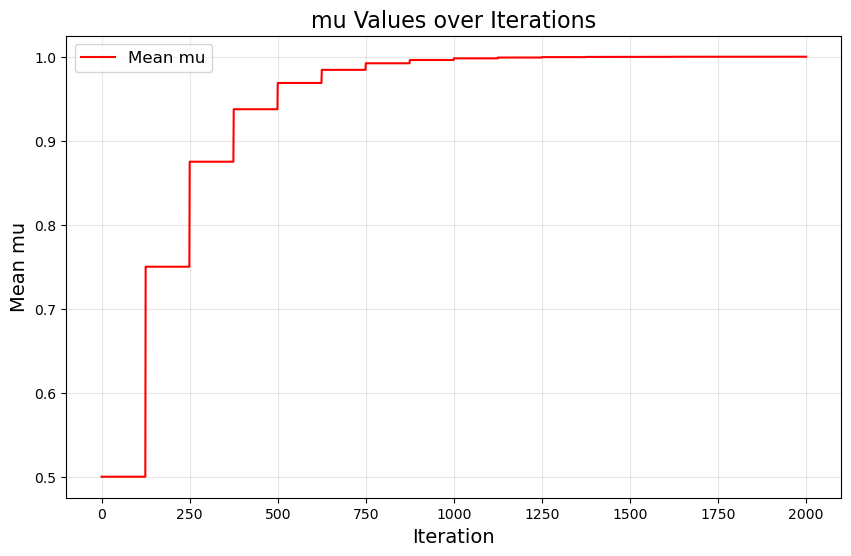

In [9]:
import torch
import matplotlib.pyplot as plt

# ECDLoss 클래스 인스턴스
ecdloss = ECDLoss()

# 설정
num_ticks = 2000  # 총 iteration 수
double = 125    # stage 업데이트 간격
ticks = range(0, num_ticks + 1)

mus = []
ratios = []

# Iteration마다 stage 업데이트 및 r/t 계산
stage = 0
for tick in ticks:
    new_stage = tick // double
    if new_stage > stage:
        stage = new_stage
        ecdloss.update_schedule(stage)
        ecdloss.update_schedule_mu(stage)
    rnd_normal = torch.randn([1, 1, 1, 1]) 
    t = (rnd_normal * ecdloss.P_std + ecdloss.P_mean).exp()
    r = ecdloss.t_to_r(t)
    ratio = r / t
    ratios.append(ratio.item())
    mu = ecdloss.mu_const(t)
    mus.append(mu.item())

    

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(ticks, ratios, label="Mean mu", color="red")
plt.title("ratio Values over Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Mean mu", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()



# 시각화
plt.figure(figsize=(10, 6))
plt.plot(ticks, mus, label="Mean mu", color="red")
plt.title("mu Values over Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Mean mu", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()


